***Step 1: Setup and Libraries***

In [ ]:
# Install necessary libraries
!pip install pandas numpy scikit-learn xgboost shap matplotlib seaborn geneticalgorithm streamlit joblib fastapi uvicorn optuna lime
!pip install shap==0.39.0

# Import necessary modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import shap
import optuna  # For hyperparameter optimization
from geneticalgorithm import geneticalgorithm as ga
import joblib
from fastapi import FastAPI
import uvicorn
from tensorflow.keras import layers, regularizers, callbacks
import tensorflow as tf
from lime.lime_tabular import LimeTabularExplainer  # For local explainability
import shap


***Step 2: Load and Clean Dataset***

In [ ]:
# Load the dataset using pandas
df = pd.read_csv('/content/Supply_Chain_Shipment_Pricing_Dataset.csv')

# Clean column names for easier access
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")

# Check available columns
print(df.columns.tolist())
print(df.head(2))

['id', 'project_code', 'pq_#', 'po_/_so_#', 'asn/dn_#', 'country', 'managed_by', 'fulfill_via', 'vendor_inco_term', 'shipment_mode', 'pq_first_sent_to_client_date', 'po_sent_to_vendor_date', 'scheduled_delivery_date', 'delivered_to_client_date', 'delivery_recorded_date', 'product_group', 'sub_classification', 'vendor', 'item_description', 'molecule/test_type', 'brand', 'dosage', 'dosage_form', 'unit_of_measure_(per_pack)', 'line_item_quantity', 'line_item_value', 'pack_price', 'unit_price', 'manufacturing_site', 'first_line_designation', 'weight_(kilograms)', 'freight_cost_(usd)', 'line_item_insurance_(usd)']
   id project_code            pq_# po_/_so_# asn/dn_#        country  \
0   1   100-CI-T01  Pre-PQ Process    SCMS-4    ASN-8  Côte d'Ivoire   
1   3   108-VN-T01  Pre-PQ Process   SCMS-13   ASN-85        Vietnam   

  managed_by  fulfill_via vendor_inco_term shipment_mode  ...  \
0   PMO - US  Direct Drop              EXW           Air  ...   
1   PMO - US  Direct Drop           

***Step 3: Handle Date Columns***

In [ ]:
# Convert relevant date columns to datetime format if they exist
date_cols = ['pq_first_sent_to_client_date', 'po_sent_to_vendor_date', 'scheduled_delivery_date',
             'delivered_to_client_date', 'delivery_recorded_date']
for col in date_cols:
    if col in df.columns:  # Check if the column exists
        df[col] = pd.to_datetime(df[col], format='%Y-%m-%d', errors='coerce')
    else:
        print(f"Warning: Column '{col}' does not exist in the DataFrame.")


***Step 4: Handle Numeric Columns and Missing Values***

In [ ]:
# Handle potential missing values
df['freight_cost_(usd)'] = pd.to_numeric(df['freight_cost_(usd)'], errors='coerce')
df['line_item_insurance_(usd)'] = pd.to_numeric(df['line_item_insurance_(usd)'], errors='coerce')

# Fill missing values using interpolation
numeric_cols = df.select_dtypes(include=['number']).columns
df[numeric_cols] = df[numeric_cols].interpolate(method='linear')

# Create total cost based on existing data columns
if 'freight_cost_(usd)' in df.columns and 'line_item_insurance_(usd)' in df.columns:
    df['total_cost'] = df['freight_cost_(usd)'] + df['line_item_insurance_(usd)']
else:
    print("Warning: One of the columns for total cost calculation is missing.")


***Step 5: Exploratory Data Analysis and Scaling***

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10324 entries, 0 to 10323
Data columns (total 34 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   id                            10324 non-null  int64         
 1   project_code                  10324 non-null  object        
 2   pq_#                          10324 non-null  object        
 3   po_/_so_#                     10324 non-null  object        
 4   asn/dn_#                      10324 non-null  object        
 5   country                       10324 non-null  object        
 6   managed_by                    10324 non-null  object        
 7   fulfill_via                   10324 non-null  object        
 8   vendor_inco_term              10324 non-null  object        
 9   shipment_mode                 9964 non-null   object        
 10  pq_first_sent_to_client_date  0 non-null      datetime64[ns]
 11  po_sent_to_v

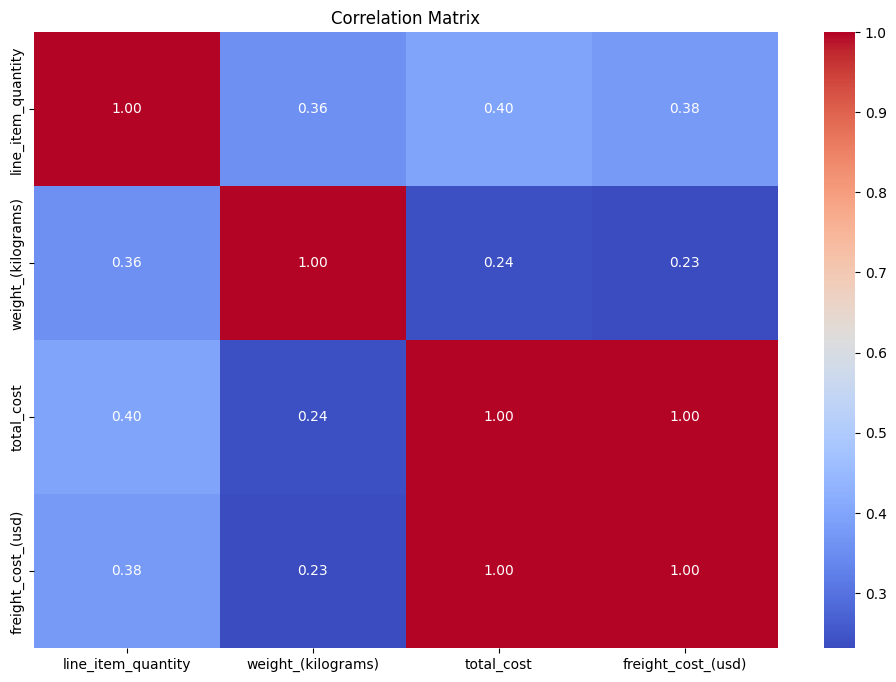

In [ ]:
# Step 1: Basic Information
print("DataFrame Info:")
print(df.info())
print("\nFirst Few Rows of Data:")
print(df.head())

# Step 2: Descriptive Statistics
print("\nDescriptive Statistics:")
print(df.describe())

# Step 3: Check for Missing Values
print("\nMissing Values in Each Column:")
print(df.isnull().sum())

# Step 4: Data Types
print("\nData Types of Each Column:")
print(df.dtypes)

# Step 5: Correlation Matrix
# Convert relevant columns to numeric, coercing errors to NaN
numeric_columns = ['line_item_quantity', 'weight_(kilograms)', 'total_cost', 'freight_cost_(usd)']
for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Check for missing values after conversion
print("\nMissing Values After Conversion to Numeric:")
print(df[numeric_columns].isnull().sum())

# Drop rows with NaN values in the columns to be analyzed
df.dropna(subset=numeric_columns, inplace=True)

# Correlation Matrix Visualization
plt.figure(figsize=(12, 8))
sns.heatmap(df[numeric_columns].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()



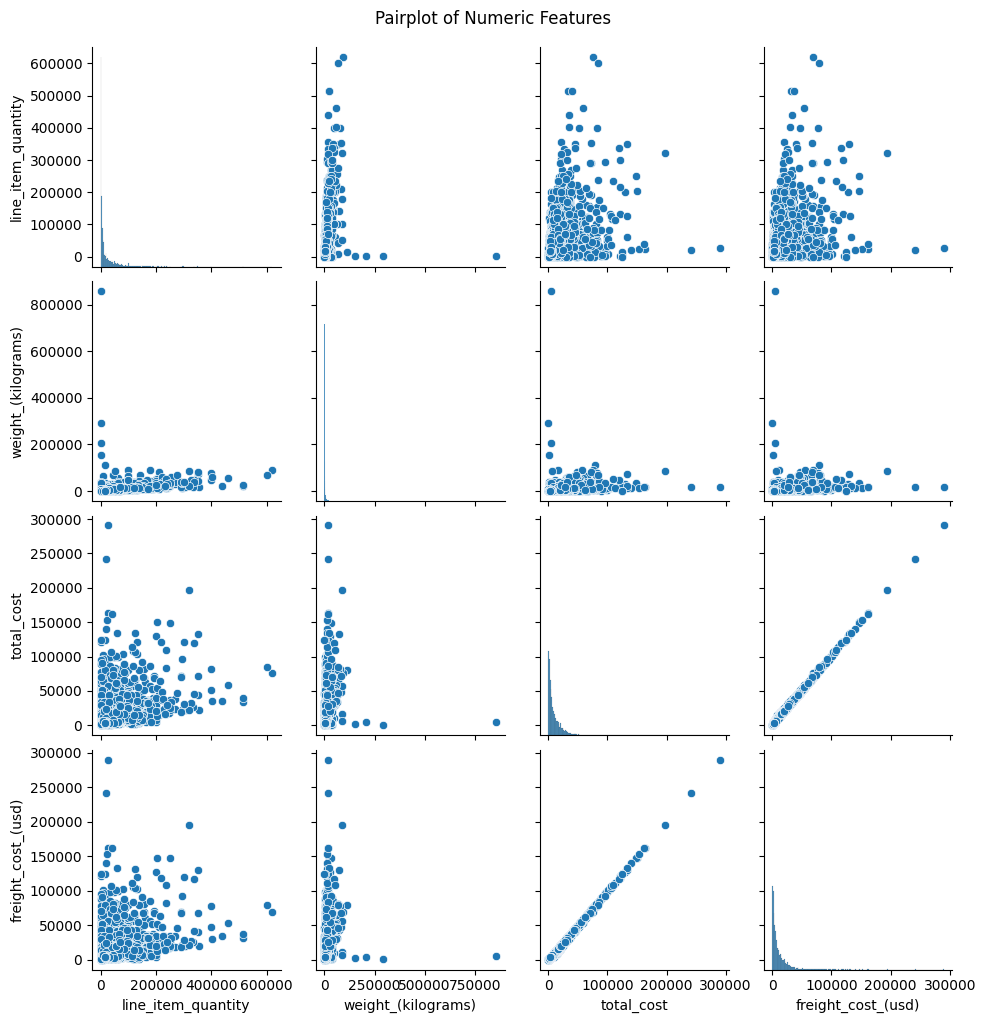

In [ ]:

# Step 6: Pairplot to Visualize Relationships
sns.pairplot(df[numeric_columns])
plt.suptitle("Pairplot of Numeric Features", y=1.02)
plt.show()


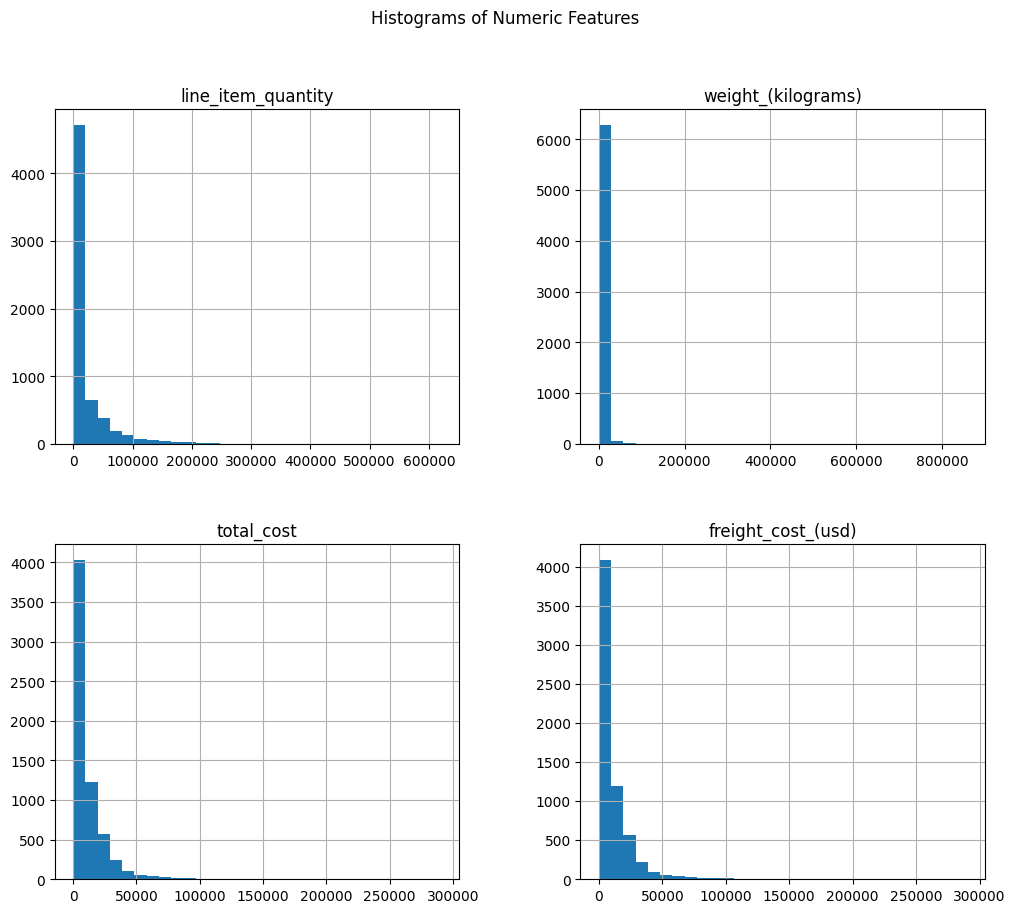

In [ ]:
# Step 7: Histograms of Numeric Features
df[numeric_columns].hist(bins=30, figsize=(12, 10))
plt.suptitle("Histograms of Numeric Features")
plt.show()


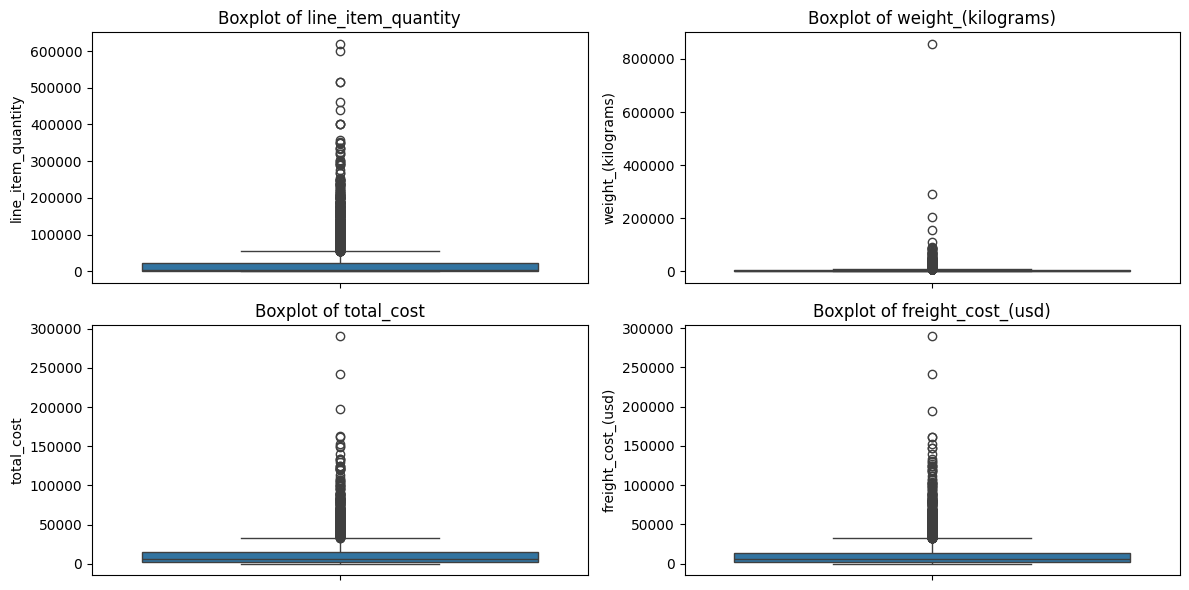

In [ ]:
# Step 8: Boxplots to Check for Outliers
plt.figure(figsize=(12, 6))
for i, col in enumerate(numeric_columns):
    plt.subplot(2, 2, i + 1)
    sns.boxplot(y=df[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()


In [ ]:
#

***Step 6: Data Scaling***

In [ ]:
# Step 6: Data Scaling
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[['line_item_quantity', 'total_cost', 'freight_cost_(usd)']])
df_scaled = pd.DataFrame(scaled_features, columns=['line_item_quantity', 'total_cost', 'freight_cost_(usd)'])


***Step 7: Predictive Modeling with XGBoost***

In [ ]:
# Step 7: Predictive Modeling with XGBoost
X = df_scaled.drop('freight_cost_(usd)', axis=1)  # Features
y = df['freight_cost_(usd)']  # Target variable

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost Model with hyperparameter optimization using Optuna
def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True),  # Updated line
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0)
    }
    xgb_model = XGBRegressor(objective='reg:squarederror', **param)
    xgb_model.fit(X_train, y_train)
    y_pred = xgb_model.predict(X_test)
    return np.sqrt(mean_squared_error(y_test, y_pred))

# Optimize using Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
print("Best parameters:", study.best_params)

# Train final model with the best parameters
xgb_reg = XGBRegressor(objective='reg:squarederror', **study.best_params)
xgb_reg.fit(X_train, y_train)

# Predict and evaluate
y_pred = xgb_reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f'RMSE: {rmse}, R2: {r2}')


[I 2024-10-27 20:21:54,726] A new study created in memory with name: no-name-dd2cb25d-18df-4bd5-b3ac-f38ea6aee57e
[I 2024-10-27 20:21:54,883] Trial 0 finished with value: 14358.688873461331 and parameters: {'n_estimators': 242, 'max_depth': 5, 'learning_rate': 0.0003397835013744886, 'subsample': 0.8327096695965859, 'colsample_bytree': 0.8314121052703125}. Best is trial 0 with value: 14358.688873461331.
[I 2024-10-27 20:21:55,133] Trial 1 finished with value: 14506.676438301049 and parameters: {'n_estimators': 487, 'max_depth': 4, 'learning_rate': 0.00013583544833075254, 'subsample': 0.538492404819219, 'colsample_bytree': 0.9275854266276373}. Best is trial 0 with value: 14358.688873461331.
[I 2024-10-27 20:21:55,336] Trial 2 finished with value: 8182.156449413304 and parameters: {'n_estimators': 310, 'max_depth': 5, 'learning_rate': 0.003578604891296675, 'subsample': 0.6974183332159309, 'colsample_bytree': 0.7999923297074725}. Best is trial 2 with value: 8182.156449413304.
[I 2024-10-27

Best parameters: {'n_estimators': 339, 'max_depth': 9, 'learning_rate': 0.0994837829040359, 'subsample': 0.5013940355198323, 'colsample_bytree': 0.8472719701386641}
RMSE: 1675.916427098434, R2: 0.987670371822244


***Step 8: Model Evaluation***

In [ ]:
# Step 8: Model Evaluation
from sklearn.metrics import mean_absolute_error

# Evaluate model performance
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R^2 Score: {r2}')


Mean Absolute Error (MAE): 488.9446504856742
Root Mean Squared Error (RMSE): 1675.916427098434
R^2 Score: 0.987670371822244
